In [66]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import pmdarima as pm
from sklearn.metrics import mean_squared_error


In [67]:
data = pd.read_table('SCiBER.txt',delimiter='\t')

# Dropping duplicates

In [68]:
data.drop_duplicates(subset=['Date'],keep='last',inplace=True)
data.groupby(data['Date']).size().sort_values(ascending=False)

Date
01.01.2013 00:15    1
21.04.2014 06:15    1
21.04.2014 04:45    1
21.04.2014 05:00    1
21.04.2014 05:15    1
                   ..
11.02.2015 13:15    1
11.02.2015 13:00    1
11.02.2015 12:45    1
11.02.2015 12:30    1
31.12.2016 23:45    1
Length: 140144, dtype: int64

# Converting the date column to datetimeindex and converting data to float32

In [69]:
data.set_index(pd.to_datetime(data['Date'],format='%d.%m.%Y %H:%M'),inplace=True)
data

,Date,Garden,School,Tunnel,Other,Other.1,Zoo,Event hall,School.1,School.2,...,School.36,(Pre-)School.2,Other.13,School.37,Office building.18,Gym.2,Gym.3,School.38,School.39,School.40
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,01.01.2013 00:15,9.5,10.4,24.0,48.0,5.0,64.0,29.4,4.2,20.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 00:30:00,01.01.2013 00:30,8.6,10.6,24.0,46.0,4.8,66.0,27.2,5.3,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 00:45:00,01.01.2013 00:45,5.5,10.5,26.0,48.0,4.4,66.0,27.6,4.9,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:00:00,01.01.2013 01:00,5.5,10.5,24.0,48.0,5.4,64.0,27.0,3.9,19.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:15:00,01.01.2013 01:15,5.4,10.6,22.0,48.0,3.6,62.0,27.0,3.9,19.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:00:00,31.12.2016 23:00,9.3,10.2,NaN,28.0,NaN,76.0,29.8,6.0,26.6,...,10.300,8.40,3.3,64.500,7.6,2.9,3.6,19.8,3.9,6.0
2016-12-31 23:15:00,31.12.2016 23:15,9.4,8.8,NaN,28.0,NaN,76.0,36.0,5.8,29.3,...,9.352,8.40,9.4,63.252,7.0,2.9,4.3,18.0,3.8,7.0
2016-12-31 23:30:00,31.12.2016 23:30,5.8,6.4,NaN,26.0,NaN,80.0,32.2,6.0,28.9,...,9.300,9.24,11.1,64.500,8.5,2.9,3.9,18.6,3.5,7.0


# Ensuring Data is continous 

In [70]:
data = data.asfreq(freq='15min')

# Filtering only office buildings 

In [72]:
office_data=data.filter(regex='Office')

# Dividing based on missing data (data availability more than 99.9%)

In [73]:
office_filter = (office_data.isnull().sum()*100/len(office_data)).sort_values(ascending=False)

In [74]:
office_filter = office_filter[office_filter<0.1]

In [75]:
office_filter

Office building.15    0.083419
Office building.14    0.083419
Office building.13    0.083419
Office building       0.083419
Office building.11    0.083419
Office building.10    0.083419
Office building.1     0.083419
Office building.8     0.083419
Office building.5     0.083419
Office building.4     0.083419
Office building.9     0.083419
dtype: float64

# Using Forward Filling method to fill missing values

In [76]:
office_data_filtered = office_data.filter(items=office_filter.index,axis=1)

In [77]:
office_data_filtered = office_data_filtered.fillna(method='ffill')

In [78]:
(office_data_filtered.isnull().sum()*100/len(office_data)).sort_values(ascending=False)

Office building.15    0.0
Office building.14    0.0
Office building.13    0.0
Office building       0.0
Office building.11    0.0
Office building.10    0.0
Office building.1     0.0
Office building.8     0.0
Office building.5     0.0
Office building.4     0.0
Office building.9     0.0
dtype: float64

In [79]:
of_da_fi = office_data_filtered

In [80]:
of_da_fi.head()

,Office building.15,Office building.14,Office building.13,Office building,Office building.11,Office building.10,Office building.1,Office building.8,Office building.5,Office building.4,Office building.9
Date,,,,,,,,,,,
2013-01-01 00:15:00,27.6,6.3,7.260,16.1,14.4,3.5,76.0,10.9,5.9,46.3,27.4
2013-01-01 00:30:00,27.8,6.0,7.200,15.7,14.9,3.5,78.0,10.7,5.8,45.7,27.6
2013-01-01 00:45:00,27.4,5.4,7.832,15.9,12.8,3.5,76.0,10.5,5.8,45.5,28.4
2013-01-01 01:00:00,27.3,3.6,8.972,15.5,15.7,3.5,78.0,10.1,5.8,45.1,27.4
2013-01-01 01:15:00,27.5,3.3,8.252,15.4,12.9,3.4,76.0,10.0,5.8,46.1,27.3


# We will remove the weekends and keep the time betwwen 5am and 7 pm 
# One day consists of 56 timesteps as (4 timesteps/hour x 14 hours a day)

In [81]:
of_da_fi = of_da_fi[(of_da_fi.index.dayofweek<5) & ((of_da_fi.index.hour>4) & (of_da_fi.index.hour<19))]

# We will use 80% of the data for training and rest for testing

In [83]:
train_rows = int(of_da_fi.shape[0]*0.80)
train = of_da_fi.iloc[:train_rows,:]
test = of_da_fi.iloc[train_rows:,:]

# Using a one office for testing

In [85]:
train_office = train.iloc[:,10]
#train_office = train_office.values.flatten()

# Lag plot of one of office buildings 

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 56)'>

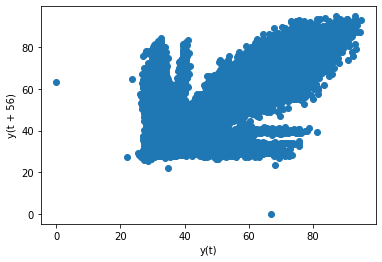

In [86]:
pd.plotting.lag_plot(train_office,lag=56*1)


In [87]:
model = pm.auto_arima(train_office,
                      m=56,
                      seasonal=True,
                      d=1,
                      start_p=1,
                      start_q=2,
                      start_P=1,
                      start_Q=2,
                     max_p=2,
                     max_q=2,
                     max_order=10,
                     trace=True,
                    low_memory=True,
                      stepwise=True
                     )

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,0,2)[56] intercept   : AIC=inf, Time=5821.41 sec
 ARIMA(0,1,0)(0,0,0)[56] intercept   : AIC=234246.374, Time=1.75 sec
 ARIMA(1,1,0)(1,0,0)[56] intercept   : AIC=inf, Time=232.17 sec
 ARIMA(0,1,1)(0,0,1)[56] intercept   : AIC=224082.227, Time=196.02 sec
 ARIMA(0,1,0)(0,0,0)[56]             : AIC=234244.378, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[56] intercept   : AIC=231483.629, Time=7.49 sec
 ARIMA(0,1,1)(1,0,1)[56] intercept   : AIC=inf, Time=640.49 sec
 ARIMA(0,1,1)(0,0,2)[56] intercept   : AIC=219822.728, Time=1119.13 sec
 ARIMA(0,1,1)(1,0,2)[56] intercept   : AIC=inf, Time=3479.06 sec
 ARIMA(0,1,0)(0,0,2)[56] intercept   : AIC=219820.754, Time=1213.78 sec
 ARIMA(0,1,0)(0,0,1)[56] intercept   : AIC=224395.177, Time=223.56 sec
 ARIMA(0,1,0)(1,0,2)[56] intercept   : AIC=inf, Time=2949.67 sec
 ARIMA(0,1,0)(1,0,1)[56] intercept   : AIC=inf, Time=594.41 sec
 ARIMA(1,1,0)(0,0,2)[56] intercept   : AIC=219822.718, Time=1381.29 sec
 ARIM

In [118]:
with open('best_fit.pkl','wb') as pkl:
    pickle.dump(model,pkl)

# We will predict on the best fitted model and calculated RMSE

In [117]:
forecast=model.predict(n_periods=int(test.shape[0]))
mean_squared_error(test.iloc[:,10],forecast,squared=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


16.638533286151056